# Descriptive Analysis Macro Features

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
if not os.path.exists("images"): 
    os.mkdir("images")
pd.set_option('display.max_columns', None)
from scipy.stats import pointbiserialr, f_oneway
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import OneHotEncoder
from models import load_ames_nei, load_ames, data_encoding, splitter, linear, encod_linear, split_linear

Here Kaggle Project Info:
 - [Column Definitions](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
 - [Column Variables](https://www.kaggle.com/datasets/ahmedmohameddawoud/ames-housing-data)


<p><a name="top"></a></p>

In this notebook we will looking at the macro influences on house prices -- beyond the four walls of the house. 

These factors include: 
- <a href="#Mo">Month and Years</a>: How does pricing vary depending on year or month sold? ('YrSold' and 'Mo Sold' respectively.) How does pricing correlate to supply and demand? 
- <a href="#nei">Neighborhoods</a>: How does pricing vary depending on neighborhood? What types of buildings and spaces charcterize these neighborhoods?
- <a href="#rate">2008 and Mortgage Rates</a>: what is the impact (if any) of the 2008 housing crisis? What was happening on a national scale and how did it playout in housing sales?
  
Finally, given all we have looked at, what predictive model serves our business case? 



#### Summary of Feature Modification

Summary of the feature we have added:

- Latitude and Long, accoplished with Geocoder

- Add neighborhood quantiles: Neighborhoods were assigned a label of Low, LowMed, MedHigh, High, for a new categroical feature, Neighborhood Quantile (Nei_quant). This was based on their coefficient values from a LassoCV model. More can be found in Modelling_1 Linear and Penalized Regression.

- Feature 'remodeled' was added as a bool, building on YearRemoAdd and YearBuilt.

- 30 Year Fixed Rate. This is the US 30 year fixed rate mortgage rate. It was mapped to the data set by year and month.

These features are added here for demonstration. They have also been worked into the load_ames_nei() function so it can easily be imported into notebooks. 

In [2]:
#Load data

housing_d = pd.read_csv('housing_cleaned.csv')
housing_X = housing_d.drop(columns = ['SalePrice', 'MapRefNo','Prop_Addr','lat','long'])
housing_y = housing_d[['SalePrice']]

In [3]:
continuous = ['SalePrice','GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','OverallQual','OverallCond','rate']
continuous_wlog = ['SalePrice','GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','YrSold','SalesPrice_log','SalePrice_box']
categorical = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
              'Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
              'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
              'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
              'Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',
               'PoolQC','Fence','MiscFeature','MoSold','YrSold','SaleType','SaleCondition', 'Nei_quant','remodeled']

In [4]:
#Load Neighborhood Quantiles
nei_quant = pd.read_pickle('nei_quant.pkl')
nei_quant.Feature = nei_quant.Feature.str.replace('Neighborhood_','')
nei_quant
housing_dn = housing_d.merge(nei_quant[['Feature','quant']], how = 'left', left_on = "Neighborhood", right_on = 'Feature').rename(
    columns = {'quant':'Nei_quant'})
housing_dn.head(2)

#Load 30 year fixed rate mortgage
data = pd.read_csv('30-year-fixed-mortgage-rate-chart.csv')
data.date = pd.to_datetime(data['date'])
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
housing_dn = housing_dn.merge(data, how = 'left', left_on = ('YrSold','MoSold'), right_on=('year','month')).drop(
    columns = ['year','month']).rename(columns = {' value':'rate'})

#Remodeled
housing_dn['remodeled'] = housing_dn.YearBuilt - housing_dn.YearRemodAdd
housing_dn['remodeled'] = housing_dn['remodeled'].apply(lambda x: 1 if x < 0 else 0)


housing_dn.head(3)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MapRefNo,Prop_Addr,lat,long,Feature,Nei_quant,date,rate,remodeled
0,909176150,856,126000,30,RL,0.0,7890,Pave,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,N,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,N,N,N,0,3,2010,WD,Normal,909176150.0,436 HAYWARD AVE,42.018564,-93.651619,SWISU,1 - Low,2010-03-01,4.99,1
1,905476230,1049,139500,120,RL,42.0,4235,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,N,N,N,0,2,2009,WD,Normal,905476230.0,3416 WEST ST,42.024855,-93.663671,Edwards,1 - Low,2009-02-01,5.07,0
2,911128020,1001,124900,30,C (all),60.0,6060,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,N,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,N,N,N,0,11,2007,WD,Normal,911128020.0,320 S 2ND ST,42.021548,-93.614068,IDOTRR,3 - MedHigh,2007-11-01,6.10,1


This can also be accomplished with load_ames_nei() function, which was added to mdoels.py.

In [5]:
load_ames_nei().head(3)

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MapRefNo,Prop_Addr,lat,long,date,rate,remodeled,Nei_quant
0,856,126000,30,RL,0,7890,Pave,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,N,0,TA,TA,CBlock,TA,TA,No,Rec,238,Unf,0,618,856,GasA,TA,Y,SBrkr,856,0,0,1,0,1,0,2,1,TA,4,Typ,1,Detchd,1939,Unf,2,399,TA,TA,Y,0,0,0,0,166,0,N,N,N,0,3,2010,WD,Normal,909176150,436 HAYWARD AVE,42.018564,-93.651619,2010-03-01,4.99,1,1 - Low
1,1049,139500,120,RL,42,4235,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552,ALQ,393,104,1049,GasA,TA,Y,SBrkr,1049,0,0,1,0,2,0,2,1,Gd,5,Typ,0,Attchd,1984,Fin,1,266,TA,TA,Y,0,105,0,0,0,0,N,N,N,0,2,2009,WD,Normal,905476230,3416 WEST ST,42.024855,-93.663671,2009-02-01,5.07,0,1 - Low
2,1001,124900,30,C (all),60,6060,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,N,0,Gd,TA,BrkTil,TA,TA,No,ALQ,737,Unf,0,100,837,GasA,Ex,Y,SBrkr,1001,0,0,0,0,1,0,2,1,Gd,5,Typ,0,Detchd,1930,Unf,1,216,TA,Po,N,154,0,42,86,0,0,N,N,N,0,11,2007,WD,Normal,911128020,320 S 2ND ST,42.021548,-93.614068,2007-11-01,6.10,1,3 - MedHigh


<p><a name="Mo"></a></p>

### Months and Years <a href="#top">[top]</a><br>


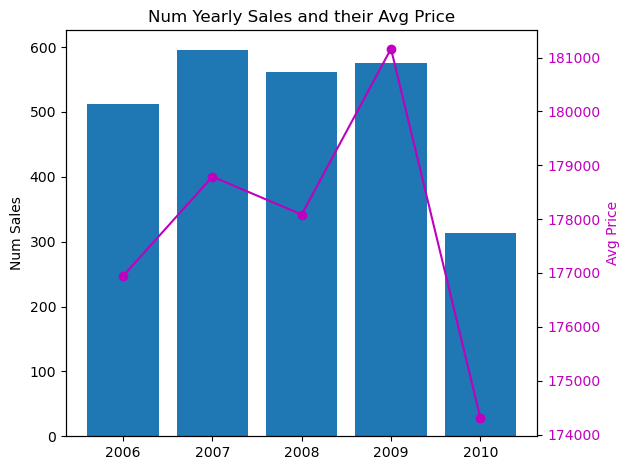

In [124]:
#Num Sales per Year

fig, ax1 = plt.subplots()
ax1.bar(housing_dn['YrSold'].value_counts().reset_index().sort_values(by = 'YrSold')['YrSold'],
        housing_dn['YrSold'].value_counts().reset_index().sort_values(by = 'YrSold')['count'])
ax1.set_ylabel('Num Sales', )
ax1.tick_params(axis='y')
ax2 = ax1.twinx()

ax2.scatter(housing_dn[['YrSold','SalePrice']].groupby('YrSold')['SalePrice'].mean().reset_index().sort_values(by = 'YrSold')['YrSold'],
            housing_dn[['YrSold','SalePrice']].groupby('YrSold')['SalePrice'].mean().reset_index().sort_values(by = 'YrSold')['SalePrice'],
           color = 'm')
ax2.plot(housing_dn[['YrSold','SalePrice']].groupby('YrSold')['SalePrice'].mean().reset_index().sort_values(by = 'YrSold')['YrSold'],
            housing_dn[['YrSold','SalePrice']].groupby('YrSold')['SalePrice'].mean().reset_index().sort_values(by = 'YrSold')['SalePrice'],
           color = 'm')
ax2.set_ylabel('Avg Price', color='m')
ax2.tick_params(axis='y', labelcolor='m')

plt.title('Num Yearly Sales and their Avg Price')
fig.tight_layout()  # Adjust the layout to make room for the labels
plt.show()
    # title = 'Num Sales per Year')

f statistic:  0.482
p value:  0.749


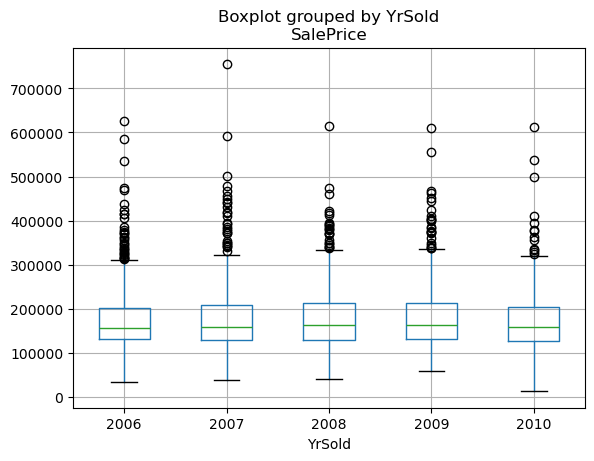

In [197]:
#Boxplot of Price by year

# Price appears to be very steady
housing_dn[['SalePrice','YrSold']].boxplot(column = 'SalePrice', by = 'YrSold')


# Check means one way Anova. Null Hypothesis is: Means for years are not stat significant. 
from scipy.stats import pointbiserialr, f_oneway
housing_n = housing_dn.copy()
housing_n['YrSold'] = housing_n['YrSold'].astype('category').cat.codes
groups = [housing_dn[housing_dn['YrSold'] == label]['SalePrice'] for label in housing_dn['YrSold'].unique()]
anova_result = f_oneway(*groups)
print('f statistic: ', str(round(anova_result.statistic,3)))
print('p value: ', str(round(anova_result.pvalue,3)))

p > .05 so we accept the Null hypothesis. There is no signicifant difference in the mean housing prices per year.

However, this does not mean that YrSold is insignificant. We don't know what kidn of houses are sold each year and in what quantities. We must complete analysis on features by year.  

Although July - December 2010 data is missing from the dataset, the average price per year does not appear to be linear. YrSold should be run as categorical to verify if the pricing behavior is linear. Overall, YrSold needs more work. 

#### Monthly View

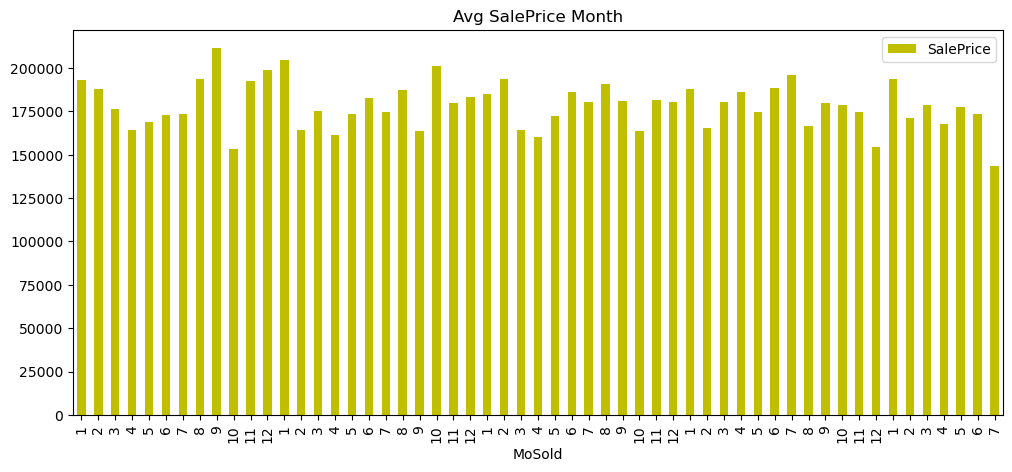

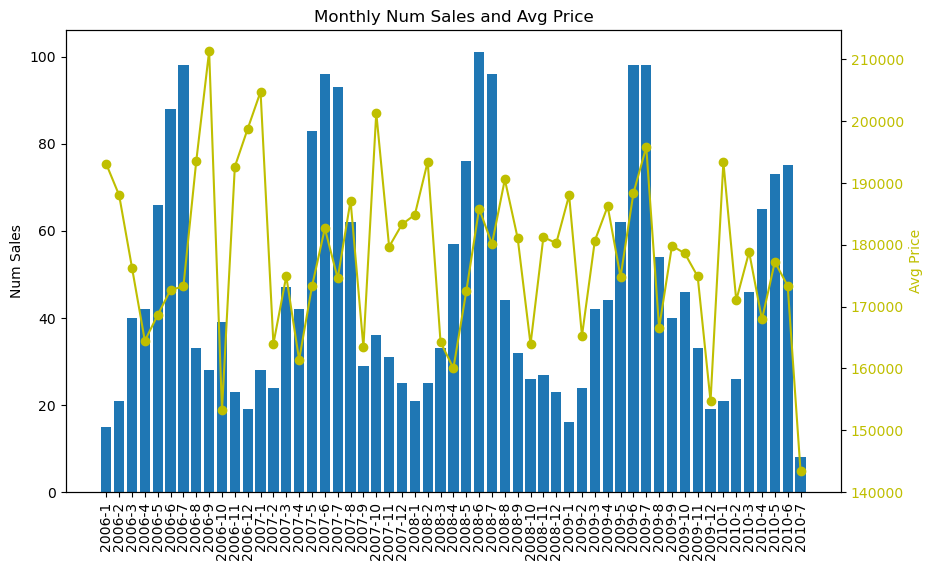

In [558]:
#Monthly Sales and Count

year_sale = housing_dn[['SalePrice','YrSold','MoSold']].groupby(
    ['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index().reset_index()
year_sale['index'] = year_sale['YrSold'].astype('str').str.cat(year_sale['MoSold'].astype('str'), sep='-')
year_sale

#Average SalePrice per month shows that MoSold needs to be a categorical feature. Prices are highest around September and January. 
housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].mean().reset_index().plot.bar(
    x = 'MoSold', y = 'SalePrice', figsize = (12,5), color = 'y', title = 'Avg SalePrice Month')


#Plot of SalesPrice Mean and Count
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(year_sale['index'],
       year_sale['count'], 
      )
plt.xticks(rotation=90)
ax2 = ax1.twinx()

ax2.scatter(year_sale['index'],
       year_sale['mean'],
         color = 'y'
      )
ax2.plot(year_sale['index'],
       year_sale['mean'],
         color = 'y', 
      )

plt.title('Monthly Num Sales and Avg Price')
ax2.set_ylabel('Avg Price', color='y')
ax1.set_ylabel('Num Sales')
ax2.tick_params(axis='y', labelcolor='y')

plt.savefig('images/mon_numsale_price.png')

<p><a name="nei"></a></p>

#### Neighborhoods and Neighborhood Quantiles <a href="#top">[top]</a><br>

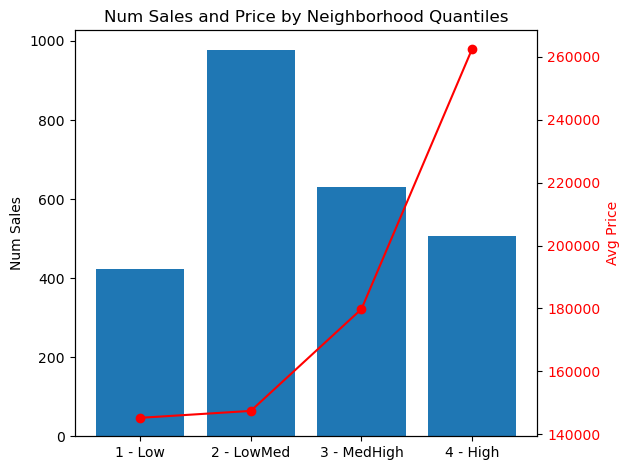

In [559]:
# Neighborhood Quantiles and prices

fig, ax1 = plt.subplots()
ax1.bar(housing_dn[['Nei_quant', 'Neighborhood','SalePrice']].groupby(['Nei_quant'])['SalePrice'].agg(['count','mean']).index, 
         housing_dn[['Nei_quant', 'Neighborhood','SalePrice']].groupby(['Nei_quant'])['SalePrice'].agg(['count','mean'])['count'], 
         linestyle = 'dotted')

ax1.set_ylabel('Num Sales', )
ax1.tick_params(axis='y',)


ax2 = ax1.twinx()
ax2.scatter(housing_dn[['Nei_quant', 'Neighborhood','SalePrice']].groupby(['Nei_quant'])['SalePrice'].agg(['count','mean']).index, 
         housing_dn[['Nei_quant', 'Neighborhood','SalePrice']].groupby(['Nei_quant'])['SalePrice'].agg(['count','mean'])['mean'], 
           color = 'red', )
ax2.plot(housing_dn[['Nei_quant', 'Neighborhood','SalePrice']].groupby(['Nei_quant'])['SalePrice'].agg(['count','mean']).index, 
         housing_dn[['Nei_quant', 'Neighborhood','SalePrice']].groupby(['Nei_quant'])['SalePrice'].agg(['count','mean'])['mean'], 
           color = 'red', )
ax2.set_ylabel('Avg Price', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Num Sales and Price by Neighborhood Quantiles')
fig.tight_layout()  # Adjust the layout to make room for the labels
plt.savefig('images/price_neig.png')

As expected, the price increases as the neighborhood quantile goes from low to high. 

General increase of sales in Mow and LowMed. General decrease in sales in MedHigh and High

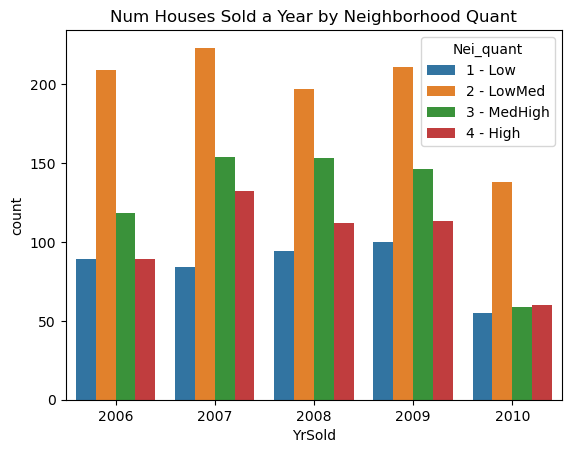

In [613]:
#Num Sales by Year

sns.barplot(housing_dn[['YrSold','Nei_quant']].value_counts().reset_index().sort_values(
    by = ['YrSold','Nei_quant']), x = 'YrSold', y = 'count', hue = 'Nei_quant', dodge = True
           ),
plt.title('Num Houses Sold a Year by Neighborhood Quant')
plt.savefig('images/numsales_nei.png')

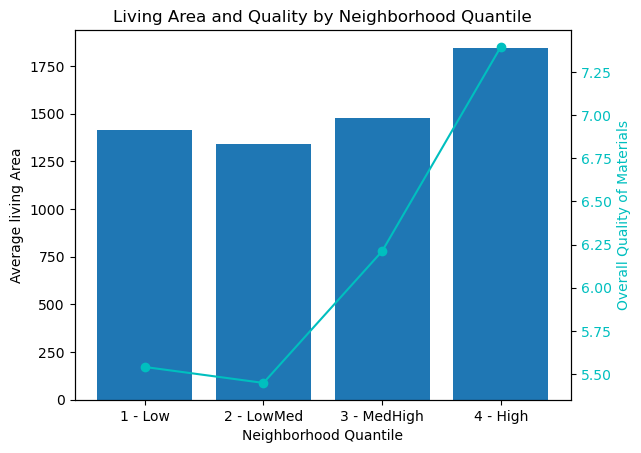

In [614]:
#Neighborhood Living Area and Quality

fig, ax1 = plt.subplots()
ax1.bar(housing_dn[['GrLivArea','Nei_quant','OverallQual','LotFrontage']].groupby('Nei_quant').mean().index, 
        housing_dn[['GrLivArea','Nei_quant','OverallQual','LotFrontage']].groupby('Nei_quant').mean().GrLivArea, 
         linestyle = 'dotted')
ax1.set_xlabel('Neighborhood Quantile')
ax1.set_ylabel('Average living Area', )
ax1.tick_params(axis='y',)

ax2 = ax1.twinx()
ax2.plot(housing_dn[['GrLivArea','Nei_quant','OverallQual','LotFrontage']].groupby('Nei_quant').mean().index, 
        housing_dn[['GrLivArea','Nei_quant','OverallQual','LotFrontage']].groupby('Nei_quant').mean().OverallQual, 
         color = 'c')
ax2.scatter(housing_dn[['GrLivArea','Nei_quant','OverallQual','LotFrontage']].groupby('Nei_quant').mean().index, 
        housing_dn[['GrLivArea','Nei_quant','OverallQual','LotFrontage']].groupby('Nei_quant').mean().OverallQual, 
         color = 'c')
ax2.set_ylabel('Overall Quality of Materials', color = 'c')
ax2.tick_params(axis='y', labelcolor='c')
plt.title('Living Area and Quality by Neighborhood Quantile')
plt.savefig('images/area_nei_quant.png')

It is hard to include 2010 data, so replotting it by semester, Jan-June and Jul-Dec for every year. 

In [645]:
housing_n[['Nei_quant','Neighborhood']].value_counts().reset_index().sort_values(by = 'Nei_quant')

,Nei_quant,Neighborhood,count
22,1 - Low,NPkVill,22
20,1 - Low,BrDale,29
3,1 - Low,Edwards,163
19,1 - Low,MeadowV,34
17,1 - Low,SWISU,41
23,1 - Low,Blueste,10
7,1 - Low,NWAmes,123
0,2 - LowMed,NAmes,408
10,2 - LowMed,Mitchel,103
24,2 - LowMed,Greens,8


/var/folders/xk/t8xh_8wx1pl_j7g1mtmxhnc40000gn/T/ipykernel_1313/486652625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MoSold'] = temp['MoSold'].apply(lambda x: 'Jan-June' if x < 7 else 'Jul - Dec')
/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

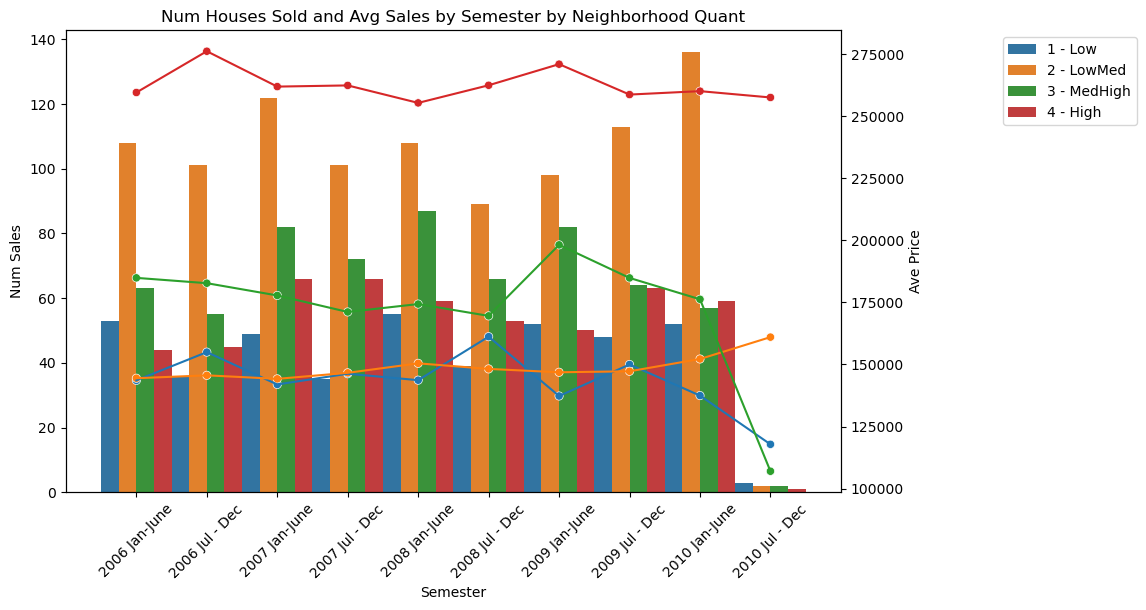

In [616]:
# Num Sales each Semester by Nei_quant

temp = housing_dn[['SalePrice','MoSold', 'YrSold','Nei_quant']]
temp['MoSold'] = temp['MoSold'].apply(lambda x: 'Jan-June' if x < 7 else 'Jul - Dec')
temp4 = temp[['SalePrice','YrSold','MoSold','Nei_quant']].groupby(['YrSold','MoSold','Nei_quant'])['SalePrice'].agg(
    ['mean','count']).reset_index()
temp4['Semester'] = temp4['YrSold'].astype('str').str.cat(temp4['MoSold'], sep=' ')

#Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(temp4,  x = 'Semester', y = 'count', 
            hue = 'Nei_quant', 
            dodge = True, 
            width = 1
           )
plt.xticks(rotation=45)
ax2 = ax1.twinx()
sns.scatterplot(temp4,  x = 'Semester', y = 'mean', hue = 'Nei_quant', legend = False,)
sns.lineplot(temp4,  x = 'Semester', y = 'mean', hue = 'Nei_quant', legend = False)

ax1.set_ylabel('Num Sales')
ax2.set_ylabel('Ave Price')
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.title('Num Houses Sold and Avg Sales by Semester by Neighborhood Quant')
plt.savefig('images/semes_count_sale_nei.png')

Observations:

- High: Avg Price is steady across all years
- MedHigh: Before January 2008, Price and Num Sales negatively correlated. After July 2007, Price and Num sales are positively correlated. Price plummets after 2010. 
- LowMed: Unlike other neighborhood quantiles, sales increase from Jul 2008 and 2010.
- Low: Avg Price is relatively steady across all until Mid 2010. Then decreases, although data is sparse.

Now that we see these trends, what kind of houses are in these neighborhoods? MSSubClass is a great feature that summarizes buildings. In fact, it needs to be introduced into the abbreviated model. 

Text(0.5, 1.0, 'Num Houses Sold a Year by MCSubClass')

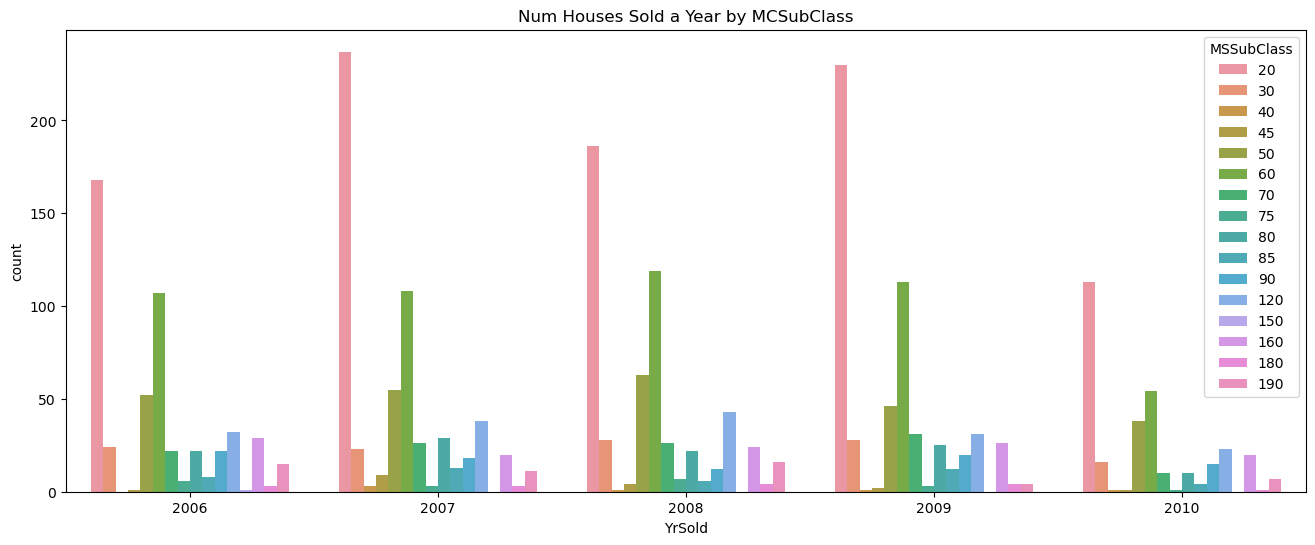

In [643]:
#MSSubClass by year

plt.figure(figsize=(16,6))
sns.barplot(housing_dn[['YrSold','MSSubClass']].value_counts().reset_index().sort_values(
    by = ['YrSold','MSSubClass']), x = 'YrSold', y = 'count', hue = 'MSSubClass', dodge = True, 
           ),
plt.title('Num Houses Sold a Year by MCSubClass')

In [618]:
#SalePrice and GrLivArea - filter by MSSubClass

housing_dn[housing_dn.MSSubClass == 20][['SalePrice', 'Nei_quant','GrLivArea']].groupby('Nei_quant').mean()

,SalePrice,GrLivArea
Nei_quant,,
1 - Low,158329.512397,1353.950413
2 - LowMed,144395.298475,1166.629630
3 - MedHigh,204617.050761,1388.781726
4 - High,296933.785714,1765.545455


<p><a name="rate"></a></p>

#### Mortgage Rate  <a href="#top">[top]</a><br>

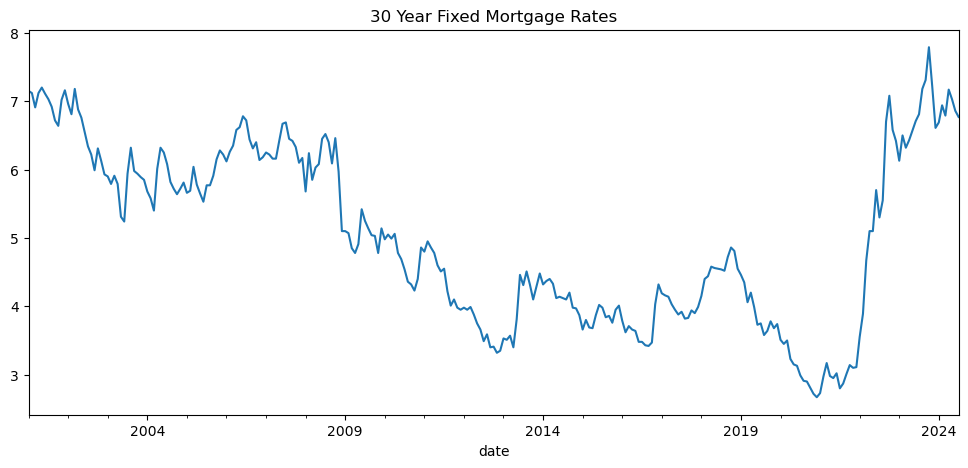

In [619]:
#Mortgage Rate 2000 - 2024

data[(data.year > 2000) ].plot(x = 'date', y = ' value', title = '30 Year Fixed Mortgage Rates', 
                                                   figsize = (12,5),legend = False)
fig = plt.gcf()
fig.savefig('images/fixed_rate_long.png')

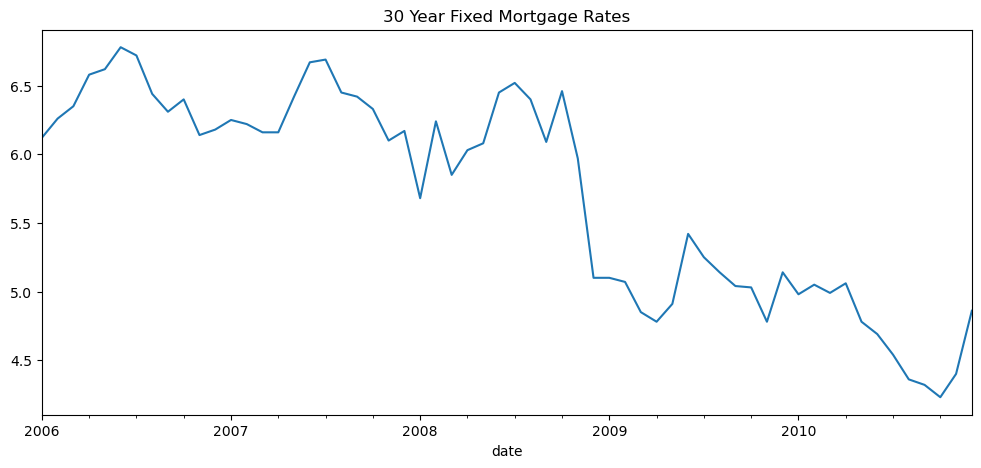

In [456]:
#2008-2010 Fixed Rate

data[(data.year > 2005) & (data.year < 2011)].plot(x = 'date', y = ' value', title = '30 Year Fixed Mortgage Rates', 
                                                   figsize = (12,5),legend = False)
fig = plt.gcf()
fig.savefig('images/fixed_rate.png')

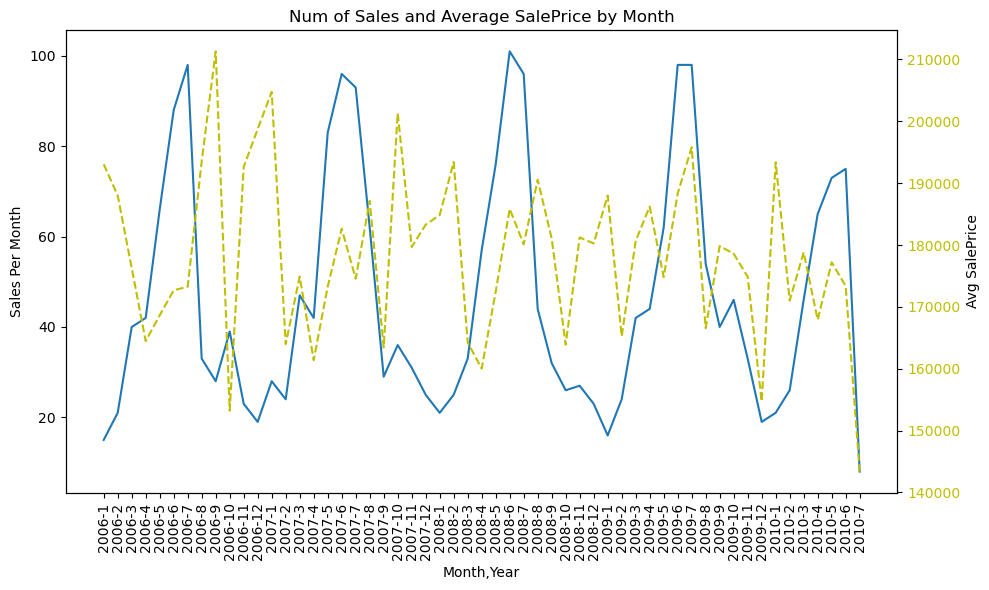

In [621]:
#Plot SalePrice, count v mean

year_month = housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index()
year_month['Semester'] = year_month['YrSold'].astype('str').str.cat(year_month['MoSold'].astype('str'), sep = '-')

fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(year_month.Semester, 
         year_month['count'], 
         )
ax1.set_xlabel('Month,Year')
ax1.set_ylabel('Sales Per Month')
ax1.tick_params(axis='y')
plt.xticks(rotation=90)
# ax1.axvline(x=26, color='y', linestyle='--', label='Vertical Line')


ax2 = ax1.twinx()
ax2.plot(housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index().index, 
         housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index()['mean'], 
         color = 'y', linestyle = '--')
ax2.set_ylabel('Avg SalePrice')
ax2.tick_params(axis='y', labelcolor='y')

plt.title('Num of Sales and Average SalePrice by Month')
fig.tight_layout()  # Adjust the layout to make room for the labels
plt.show()

# housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean'])

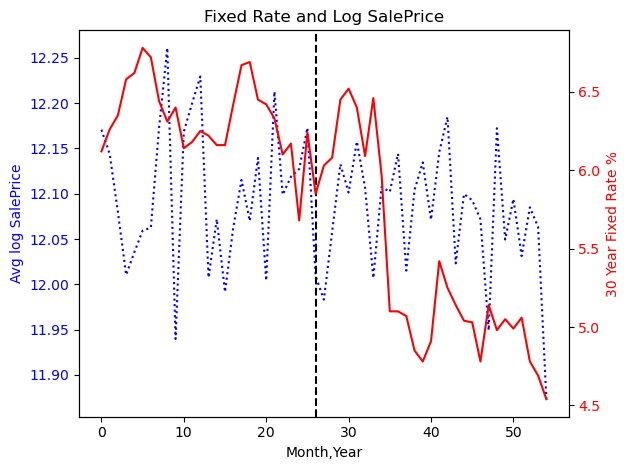

In [633]:
#Plot Fixed Rate and Log SalePrice

temp = housing_dn[['SalePrice','MoSold', 'YrSold']]
temp = temp.groupby(['YrSold', 'MoSold'])[['SalePrice']].mean().reset_index()

fig, ax1 = plt.subplots()
ax1.plot(temp.index, np.log(temp.SalePrice), color = 'b', linestyle = 'dotted')
ax1.set_xlabel('Month,Year')
ax1.set_ylabel('Avg log SalePrice', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axvline(x=26, color='k', linestyle='--', label='Vertical Line')
ax2 = ax1.twinx()
ax2.plot(data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index().index,
            data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()[' value'],
           color = 'red')
ax2.set_ylabel('30 Year Fixed Rate %', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Fixed Rate and Log SalePrice')
fig.tight_layout()  # Adjust the layout to make room for the labels
plt.show()

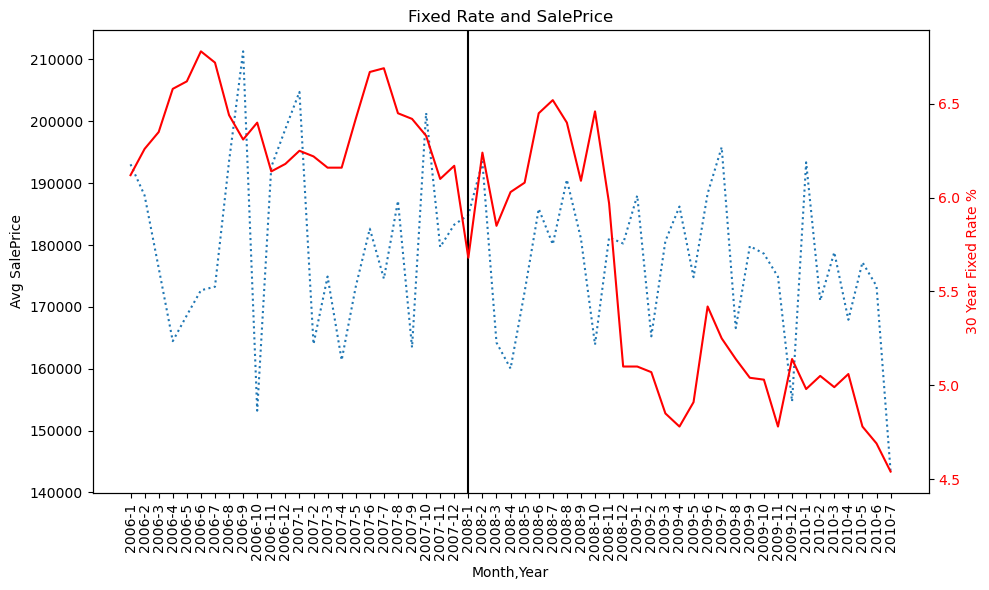

In [635]:
#Plot Fixed Rate and SalePrice

temp = housing_dn[['SalePrice','MoSold', 'YrSold']]
temp = temp.groupby(['YrSold', 'MoSold'])[['SalePrice']].mean().reset_index()
temp2 = temp.copy()
temp2['Semester'] = temp2['YrSold'].astype('str').str.cat(temp2['MoSold'].astype('str'), sep = '-')


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(temp2.Semester, temp2.SalePrice, linestyle = 'dotted')
ax1.set_xlabel('Month,Year')
ax1.set_ylabel('Avg SalePrice', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.axvline(x=24, color='k', label='Vertical Line')
plt.xticks(rotation = 90)

ax2 = ax1.twinx()
ax2.plot(data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index().index,
            data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()[' value'],
           color = 'red')
ax2.set_ylabel('30 Year Fixed Rate %', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Fixed Rate and SalePrice')
fig.tight_layout()  # Adjust the layout to make room for the labels
# # plt.show()
plt.savefig('images/rate_price.png')

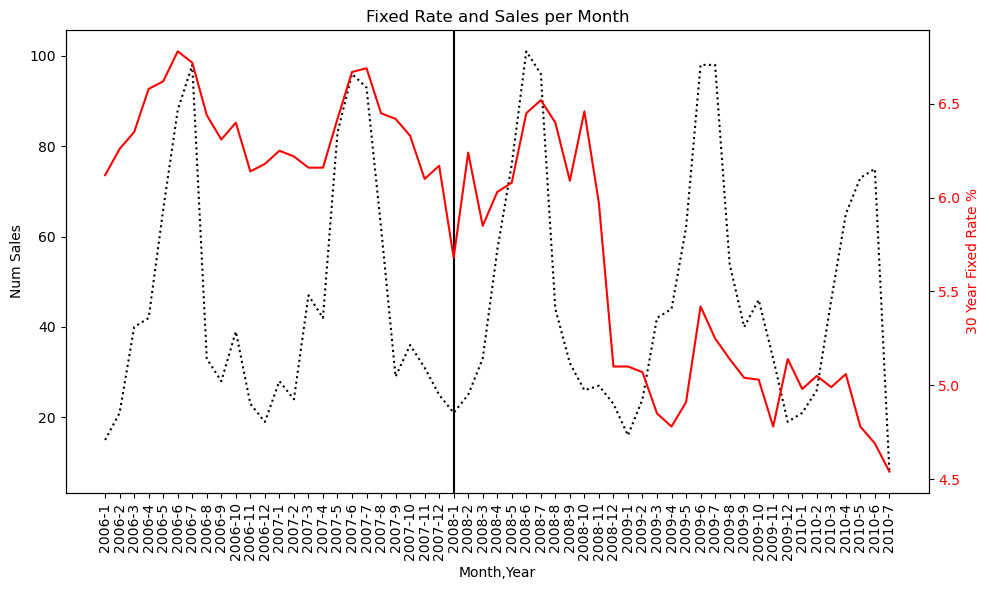

In [637]:
#Plot Fixed Rate and SalePrice

year_count = housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index()
year_count['Semester'] = year_count['YrSold'].astype('str').str.cat(year_count['MoSold'].astype('str'), sep = '-')
year_count

fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(year_count.Semester, 
         year_count['count'], 
         color = 'k', linestyle = 'dotted')
ax1.set_xlabel('Month,Year')
ax1.set_ylabel('Num Sales', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.axvline(x=24, color='k', label='Vertical Line')
plt.xticks(rotation = 90)


ax2 = ax1.twinx()
ax2.plot(data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index().index,
            data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()[' value'],
           color = 'red', )
ax2.set_ylabel('30 Year Fixed Rate %', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Fixed Rate and Sales per Month')
fig.tight_layout()  # Adjust the layout to make room for the labels
# plt.show()
plt.savefig('images/rate_numsales.png')

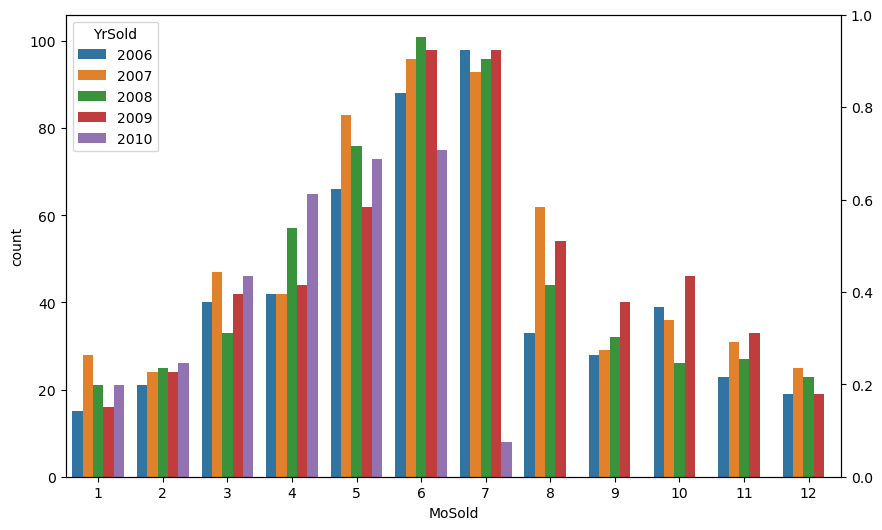

In [154]:
#Sales Per Month

# housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].count().reset_index().plot.bar(
#     x = 'MoSold', y = 'SalePrice', figsize = (12,5), color = 'g', title = 'Number of Sales per month Month')

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data = housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
    x = 'MoSold', y = 'count', hue = 'YrSold')

ax2 = ax1.twinx()

# sns.scatterplot(data = housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
#     x = 'MoSold', y = 'mean', hue = 'YrSold')

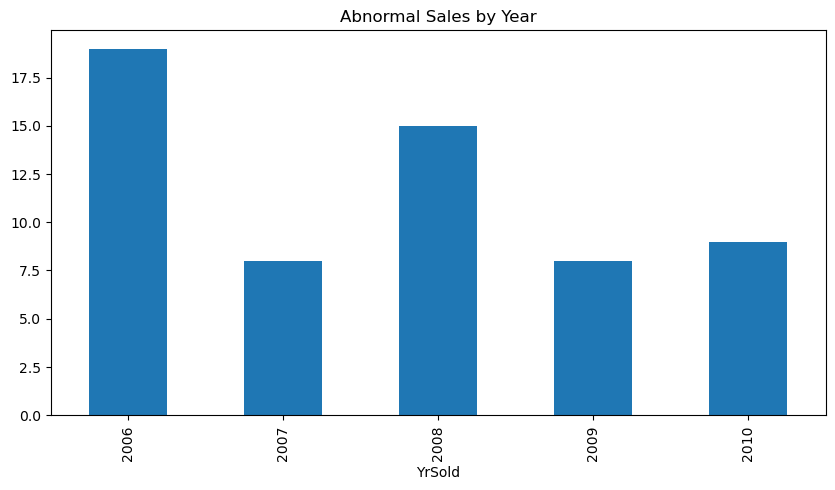

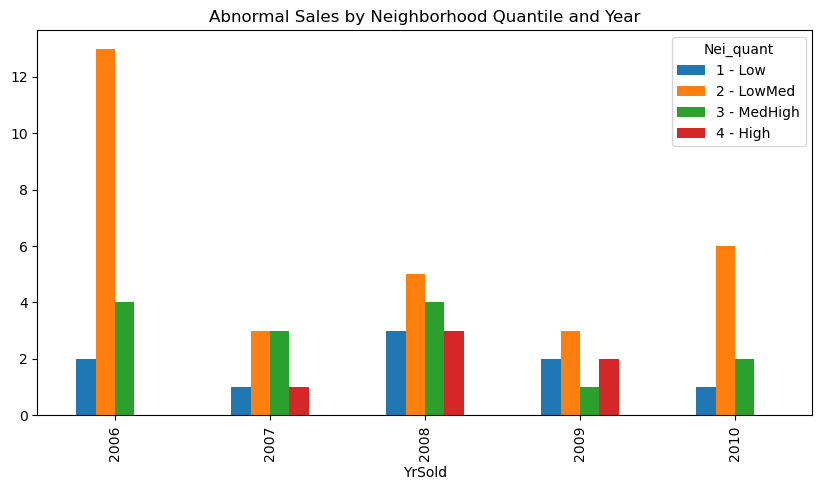

In [638]:
#Abnormal Sales by Year and Neighborhood

housing_dn[housing_dn.SaleCondition == 'Abnorml'][['YrSold', 'Nei_quant','MSSubClass']].value_counts(
    ).reset_index().sort_values(by = ['YrSold','Nei_quant'])

housing_dn[housing_dn.SaleCondition == 'Abnorml'][['YrSold', 'Nei_quant','MSSubClass']].value_counts(
    ).reset_index().sort_values(by = ['YrSold','Nei_quant']).groupby('YrSold')['count'].sum().plot.bar(
    title = 'Abnormal Sales by Year', figsize = (10,5))
plt.savefig('images/abn_year.png')

housing_dn[housing_dn.SaleCondition == 'Abnorml'][['YrSold', 'Nei_quant']].value_counts(
    ).reset_index().sort_values(by = ['YrSold','Nei_quant']).pivot(index=('YrSold'), columns='Nei_quant', values='count').plot.bar(
     title = 'Abnormal Sales by Neighborhood Quantile and Year', figsize = (10,5))
plt.savefig('images/abn_year_nei.png')

Rate appears to be inverse of SalePrice until mid 2008, and then follows the same trend. 

In [640]:
#correlation matrix of Num of Sales, SalePrice, FixedRate

pd.concat([housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()], axis = 1)[['count','mean',' value']].rename(
    columns = {'count':'Num Sales','mean':'Avg Price',' value':'Fixed Rate'}).corr()

,Num Sales,Avg Price,Fixed Rate
Num Sales,1.000000,-0.021921,0.203713
Avg Price,-0.021921,1.000000,0.145702
Fixed Rate,0.203713,0.145702,1.000000


Correlation values are not informative. 

However correlations are high once segmented. In some cases, fixed rate is a proxy for 'supply' aka num of sales per month. Generally, people think of higher supply reduced demand and Saleprice. The inverse behavior of count and avg salesprice demonstrate this relationship between high supply and lower SalePrice. 

In [642]:
pd.concat([
    pd.concat([housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()], axis = 1)[['count','mean',' value']].loc[0:13,].rename(
    columns = {'count':'Sales Month','mean':'Avg Price',' value':'Fixed Rate'}).corr().round(2),
    pd.concat([housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()], axis = 1)[['count','mean',' value']].loc[13:25,].rename(
    columns = {'count':'Sales Month','mean':'Avg Price',' value':'Fixed Rate'}).corr().round(2),
    pd.concat([housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()], axis = 1)[['count','mean',' value']].loc[25:37,].rename(
    columns = {'count':'Sales Month','mean':'Avg Price',' value':'Fixed Rate'}).corr().round(2),
    pd.concat([housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()], axis = 1)[['count','mean',' value']].loc[37:49,].rename(
    columns = {'count':'Sales Month','mean':'Avg Price',' value':'Fixed Rate'}).corr().round(2),
    pd.concat([housing_dn[['SalePrice','YrSold','MoSold']].groupby(['YrSold','MoSold'])['SalePrice'].agg(['count','mean']).reset_index(),
data[(data.year > 2005) & (data.year < 2011)].loc[417:471,].reset_index()], axis = 1)[['count','mean',' value']].loc[49:,].rename(
    columns = {'count':'Sales Month','mean':'Avg Price',' value':'Fixed Rate'}).corr().round(2)],
          keys = ['2006','2007','2008','2009','2010'],
    axis = 1)

2006                             2007                       \
            Sales Month Avg Price Fixed Rate Sales Month Avg Price Fixed Rate   
Sales Month        1.00     -0.46       0.93        1.00     -0.06       0.77   
Avg Price         -0.46      1.00      -0.51       -0.06      1.00      -0.05   
Fixed Rate         0.93     -0.51       1.00        0.77     -0.05       1.00   

                   2008                             2009                       \
            Sales Month Avg Price Fixed Rate Sales Month Avg Price Fixed Rate   
Sales Month        1.00      0.03       0.58        1.00      0.54       0.56   
Avg Price          0.03      1.00       0.12        0.54      1.00       0.05   
Fixed Rate         0.58      0.12       1.00        0.56      0.05       1.00   

                   2010                       
            Sales Month Avg Price Fixed Rate  
Sales Month        1.00      0.71       0.18  
Avg Price          0.71      1.00       0.59  
Fixed Rate         0.18      0.59       1.00

#### Feaure Set Exploration

In [647]:
# MLR with MLR Top 15. Swapping in Neighborhood, Nei_quant, YrSold, MoSold, Rate, MSSubClass

MLR_features = ['GarageCars','Fireplaces', 'FullBath', 'BsmtFullBath', 'HalfBath', 'YearBuilt', 'OverallCond',
 'OverallQual','GrLivArea','remodeled']

test_list = ['Null',',No Base', 'Mo', 'Yr', 'Mo Yr', 'Mo Yr Rate', 'Neighborhood', 'Nei_q', 'rate','rate nei_q', 'MS',
            'MS, No Gr','MS Nei_q, No Gr' ,'MS Rate Nei_q, No Gr', 'MS Rate Nei_q, No Built', 'MS Rate', 'Neighbor MS','Nei_q MS', 
             'Nei_q MS, No Base, No Yr' ,'Nei_q MS Rate, No Base, No Yr ', 'MS, No Yr, No Base', 'Nei_ MS Rate, No HBath',
            'Nei_ MS, No HBath','Null, No Hbath', 'Nei_q Rate No HBath',  'Neigh Rate No HBath', 'Neigh MS, No HBath','nei_q MS, No rem bath Gar Fir',
            'Nei_ MS, No FBath, HBath, rem','Nei_q, MS, YrRemo, no YearB']

pd.DataFrame([
#Null
linear(housing_dn[MLR_features], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],
    
#No Basement Full Bath
linear(housing_dn[MLR_features].drop(columns = 'BsmtFullBath'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

# Add in MoSold
linear(housing_dn[MLR_features+['MoSold']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],
    
# Add in YrSold
linear(housing_dn[MLR_features+['YrSold']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MoSold and YrSold
linear(housing_dn[MLR_features+['MoSold'] + ['YrSold']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MoSold and YrSold and rate
linear(housing_dn[MLR_features+['MoSold'] + ['YrSold'] + ['rate']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add Neighborhood
linear(housing_dn[MLR_features+['Neighborhood']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add Nei_quant
linear(housing_dn[MLR_features+['Nei_quant']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add rate
linear(housing_dn[MLR_features+['rate']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add rate and Nei_quant
linear(housing_dn[MLR_features+['rate']+['Nei_quant']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass
linear(housing_dn[MLR_features+['MSSubClass']], housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, No Gr
linear(housing_dn[MLR_features+['MSSubClass']].drop(columns = 'GrLivArea'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],
    
#Add MSSubClass, Nei_quant drop GrLiv
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']].drop(columns = 'GrLivArea'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_quant drop GrLiv
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant'] + ['rate']].drop(columns = 'GrLivArea'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_quant drop YearBuilt
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant'] + ['rate']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, rate, no Yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['rate']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Neighbor no yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['Neighborhood']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q no yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, no yr, no base
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']].drop(columns = ['YearBuilt', 'BsmtFullBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, rate, no yr, no base
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant'] + ['rate']].drop(columns = ['YearBuilt', 'BsmtFullBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, no yr, no base
linear(housing_dn[MLR_features+['MSSubClass']].drop(columns = ['YearBuilt', 'BsmtFullBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, rate, drop half bath
linear(housing_dn[MLR_features +['MSSubClass']  + ['rate']+ ['Nei_quant']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, drop half bath
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#drop half bath
linear(housing_dn[MLR_features].drop(columns = ['HalfBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#nei_q rate drop half bath
linear(housing_dn[MLR_features + ['rate']+ ['Nei_quant']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],
    
#neiborhood rate drop half bath
linear(housing_dn[MLR_features + ['rate']+ ['Neighborhood']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#neiborhood rate drop half bath
linear(housing_dn[MLR_features + ['MSSubClass']+ ['Neighborhood']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#neighborhood_w MS, dropping many features
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['HalfBath','remodeled','GarageCars','Fireplaces']), housing_dnG[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

#neighborhood_w MS and Nei, dropping Full, Half, remodeled
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['FullBath', 'HalfBath','remodeled']), housing_dnG[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],
    
#Add MSSubClass, Nei_q yrremo no yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']+['YearRemodAdd']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],
], index = test_list).sort_values(by = 'Adjusted r2', ascending = False).style.apply(
    lambda x: ['background-color: yellow' if x.name == 'Null' else '' for i in x], axis=1)


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
"Nei_ MS, No FBath, HBath, rem",0.907000,0.902000,0.897000,0.015000,0.087000,0.122000
"Nei_ MS, No HBath",0.907000,0.902000,0.898000,0.015000,0.088000,0.122000
"Neigh MS, No HBath",0.910000,0.901000,0.901000,0.014000,0.086000,0.118000
"Nei_ MS Rate, No HBath",0.906000,0.901000,0.898000,0.015000,0.088000,0.122000
"nei_q MS, No rem bath Gar Fir",0.896000,0.891000,0.888000,0.016000,0.093000,0.126000
"Nei_q, MS, YrRemo, no YearB",0.896000,0.890000,0.890000,0.016000,0.092000,0.126000
MS,0.895000,0.890000,0.887000,0.016000,0.093000,0.126000
Neighbor MS,0.898000,0.887000,0.893000,0.016000,0.090000,0.126000
Neighborhood,0.894000,0.886000,0.889000,0.017000,0.094000,0.130000
Nei_q MS,0.891000,0.885000,0.885000,0.017000,0.092000,0.130000


In [436]:
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['FullBath', 'HalfBath','remodeled']), housing_dnG[['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1]
# linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['FullBath','remodeled','GarageCars','Fireplaces']), housing_dnG[['SalePrice']], log = 'yes',
       # cont_trans = 'ss')[1],

{'r2': 0.907,
 'Adjusted r2': 0.902,
 'train r2': 0.897,
 'MSE': 0.015,
 'Abs Error': 0.087,
 'RMSE': 0.122}

In [349]:
#neighborhood_w MS, dropping many features
linear(housing_dn[housing_dn.YrSold <2007][MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['HalfBath','remodeled','GarageCars','Fireplaces']), housing_dnG[housing_dn.YrSold <2007][['SalePrice']], log = 'yes',
       cont_trans = 'ss')[1],

({'r2': 0.873,
  'Adjusted r2': 0.836,
  'train r2': 0.915,
  'MSE': 0.019,
  'Abs Error': 0.102,
  'RMSE': 0.138},)

In [651]:
# LassoCV with MLR Top 15. Swapping in Neighborhood, Nei_quant, YrSold, MoSold, Rate, MSSubClass

MLR_features = ['GarageCars','Fireplaces', 'FullBath', 'BsmtFullBath', 'HalfBath', 'YearBuilt', 'OverallCond',
 'OverallQual','GrLivArea','remodeled']

test_list = ['Null',',No Base', 'Mo', 'Yr', 'Mo Yr', 'Mo Yr Rate', 'Neighborhood', 'Nei_q', 'rate','rate nei_q', 'MS',
            'MS, No Gr','MS Nei_q, No Gr' ,'MS Rate Nei_q, No Gr', 'MS Rate Nei_q, No Built', 'MS Rate', 'Neighbor MS','Nei_q MS', 
             'Nei_q MS, No Base, No Yr' ,'Nei_q MS Rate, No Base, No Yr ', 'MS, No Yr, No Base', 'Nei_ MS Rate, No HBath',
            'Nei_ MS, No HBath','Null, No Hbath', 'Nei_q Rate No HBath',  'Neigh Rate No HBath', 'Neigh MS, No HBath','nei_q MS, No rem bath Gar Fir',
            'Nei_ MS, No FBath, HBath, rem','Nei_q, MS, YrRemo, no YearB']

pd.DataFrame([
#Null
linear(housing_dn[MLR_features], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],
    
#No Basement Full Bath
linear(housing_dn[MLR_features].drop(columns = 'BsmtFullBath'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

# Add in MoSold
linear(housing_dn[MLR_features+['MoSold']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],
    
# Add in YrSold
linear(housing_dn[MLR_features+['YrSold']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MoSold and YrSold
linear(housing_dn[MLR_features+['MoSold'] + ['YrSold']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MoSold and YrSold and rate
linear(housing_dn[MLR_features+['MoSold'] + ['YrSold'] + ['rate']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add Neighborhood
linear(housing_dn[MLR_features+['Neighborhood']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add Nei_quant
linear(housing_dn[MLR_features+['Nei_quant']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add rate
linear(housing_dn[MLR_features+['rate']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add rate and Nei_quant
linear(housing_dn[MLR_features+['rate']+['Nei_quant']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass
linear(housing_dn[MLR_features+['MSSubClass']], housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, No Gr
linear(housing_dn[MLR_features+['MSSubClass']].drop(columns = 'GrLivArea'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],
    
#Add MSSubClass, Nei_quant drop GrLiv
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']].drop(columns = 'GrLivArea'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_quant drop GrLiv
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant'] + ['rate']].drop(columns = 'GrLivArea'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_quant drop YearBuilt
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant'] + ['rate']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, rate, no Yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['rate']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Neighbor no yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['Neighborhood']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q no yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, no yr, no base
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']].drop(columns = ['YearBuilt', 'BsmtFullBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, rate, no yr, no base
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant'] + ['rate']].drop(columns = ['YearBuilt', 'BsmtFullBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, no yr, no base
linear(housing_dn[MLR_features+['MSSubClass']].drop(columns = ['YearBuilt', 'BsmtFullBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, rate, drop half bath
linear(housing_dn[MLR_features +['MSSubClass']  + ['rate']+ ['Nei_quant']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#Add MSSubClass, Nei_q, drop half bath
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#drop half bath
linear(housing_dn[MLR_features].drop(columns = ['HalfBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#nei_q rate drop half bath
linear(housing_dn[MLR_features + ['rate']+ ['Nei_quant']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],
    
#neiborhood rate drop half bath
linear(housing_dn[MLR_features + ['rate']+ ['Neighborhood']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#neiborhood rate drop half bath
linear(housing_dn[MLR_features + ['MSSubClass']+ ['Neighborhood']].drop(columns = ['HalfBath']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#neighborhood_w MS, dropping many features
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['HalfBath','remodeled','GarageCars','Fireplaces']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],

#neighborhood_w MS and Nei, dropping Full, Half, remodeled
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['FullBath', 'HalfBath','remodeled']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],
    
#Add MSSubClass, Nei_q yrremo no yr Built
linear(housing_dn[MLR_features+['MSSubClass']+ ['Nei_quant']+['YearRemodAdd']].drop(columns = 'YearBuilt'), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[1],
], index = test_list).sort_values(by = 'Adjusted r2', ascending = False).style.apply(
    lambda x: ['background-color: yellow' if x.name == 'Null' else '' for i in x], axis=1)


,r2,Adjusted r2,train r2,MSE,Abs Error,RMSE
"Nei_ MS, No FBath, HBath, rem",0.906000,0.901000,0.897000,0.015000,0.419000,0.122000
"Nei_ MS, No HBath",0.906000,0.901000,0.898000,0.015000,0.419000,0.122000
"Neigh MS, No HBath",0.909000,0.900000,0.900000,0.014000,0.418000,0.118000
"Nei_ MS Rate, No HBath",0.905000,0.899000,0.898000,0.015000,0.419000,0.122000
"nei_q MS, No rem bath Gar Fir",0.896000,0.891000,0.888000,0.016000,0.417000,0.126000
"Nei_q, MS, YrRemo, no YearB",0.895000,0.889000,0.890000,0.016000,0.416000,0.126000
MS,0.894000,0.889000,0.886000,0.017000,0.414000,0.130000
Neighbor MS,0.897000,0.886000,0.893000,0.016000,0.415000,0.126000
Neighborhood,0.894000,0.886000,0.889000,0.017000,0.418000,0.130000
Neigh Rate No HBath,0.892000,0.884000,0.887000,0.017000,0.418000,0.130000


In [659]:
#neighborhood_w MS and Nei, dropping Full, Half, remodeled
linear(housing_dn[MLR_features +['MSSubClass'] + ['Nei_quant']].drop(columns = ['FullBath', 'HalfBath','remodeled']), housing_dn[['SalePrice']].values.ravel(), model = 'lassocv', log = 'yes',
       cont_trans = 'ss')[2]

,Feature,Coefficient
6,GrLivArea,0.156754
3,YearBuilt,0.109445
5,OverallQual,0.103154
4,OverallCond,0.059672
24,Nei_quant_4 - High,0.053219
0,GarageCars,0.038983
2,BsmtFullBath,0.038111
1,Fireplaces,0.028211
23,Nei_quant_3 - MedHigh,0.015023
22,Nei_quant_2 - LowMed,0.006553


In [202]:
##END

In [590]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(housing_dn[continuous]), columns = housing_dn[continuous].columns).describe()

,SalePrice,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,OverallQual,OverallCond,rate
count,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2559.000000,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03,2.559000e+03
mean,9.995912e-17,-1.707635e-16,-2.776642e-17,2.776642e-18,1.305022e-15,-1.890893e-15,2.221314e-17,-8.329927e-17,-2.776642e-18,-1.041241e-17,2.471212e-16,0.000000,4.650876e-17,7.635766e-18,-8.329927e-17,2.776642e-18,8.677007e-17,5.553284e-18,-3.887299e-17,-3.061248e-16,-2.249080e-16,-5.275620e-17,2.387912e-16,-1.249489e-16,1.166190e-16,3.887299e-17,-5.275620e-17,-2.290730e-17,-2.776642e-17,5.553284e-18,1.665985e-17,-2.776642e-18,4.442627e-17,1.665985e-16,-1.353613e-16
std,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00,1.000195e+00
min,-2.210472e+00,-2.359696e+00,-1.682652e+00,-1.082410e+00,-3.324595e+00,-1.654483e+00,-5.636480e-01,-1.037017e+00,-3.047803e-01,-1.271907e+00,-2.492226e+00,-2.156655,-7.949750e-01,-9.600438e-02,-8.416303e-01,-2.531343e-01,-2.849545e+00,-7.589589e-01,-3.471675e+00,-5.118561e+00,-2.860393e+00,-9.334198e-01,-4.387336e+00,-2.369278e+00,-2.252642e+00,-7.451510e-01,-7.074776e-01,-3.596496e-01,-9.971221e-02,-2.864122e-01,-5.501643e-02,-9.813492e-02,-3.720734e+00,-4.130573e+00,-1.943804e+00
25%,-6.445953e-01,-7.669658e-01,-4.855277e-01,-3.322213e-01,-5.731276e-01,-9.209389e-01,-5.636480e-01,-1.037017e+00,-3.047803e-01,-7.634322e-01,-5.896710e-01,-0.726373,-7.949750e-01,-9.600438e-02,-8.416303e-01,-2.531343e-01,-1.013235e+00,-7.589589e-01,-1.037031e+00,-1.998987e-01,-9.055069e-01,-9.334198e-01,1.805410e-01,-1.015329e+00,-7.139998e-01,-7.451510e-01,-7.074776e-01,-3.596496e-01,-9.971221e-02,-2.864122e-01,-5.501643e-02,-9.813492e-02,-7.743133e-01,-5.541439e-01,-1.145554e+00
50%,-2.438113e-01,-1.036694e-01,1.429626e-01,-9.014570e-02,5.143867e-02,3.994411e-01,-5.636480e-01,-1.381449e-01,-3.047803e-01,-2.149381e-01,-1.410232e-01,-0.199987,-7.949750e-01,-9.600438e-02,-8.416303e-01,-2.531343e-01,8.230743e-01,-7.589589e-01,1.802912e-01,-1.998987e-01,-2.538780e-01,6.066326e-01,2.272235e-01,3.386194e-01,3.843962e-02,-7.451510e-01,-3.071194e-01,-3.596496e-01,-9.971221e-02,-2.864122e-01,-5.501643e-02,-9.813492e-02,-3.770819e-02,-5.541439e-01,3.654190e-01
75%,4.208223e-01,5.063996e-01,6.517404e-01,1.683346e-01,9.629679e-01,9.373737e-01,3.318982e-01,6.699082e-01,-3.047803e-01,5.736693e-01,5.475432e-01,0.581617,8.650801e-01,-9.600438e-02,1.084785e+00,-2.531343e-01,8.230743e-01,1.243284e+00,1.802912e-01,-1.998987e-01,3.977508e-01,6.066326e-01,2.785742e-01,3.386194e-01,5.255959e-01,5.548309e-01,3.473123e-01,-3.596496e-01,-9.971221e-02,-2.864122e-01,-5.501643e-02,-9.813492e-02,6.988969e-01,3.399634e-01,7.787985e-01
max,7.705072e+00,6.529295e+00,7.684846e+00,2.520737e+01,1.334332e+00,1.279694e+00,8.533964e+00,4.291010e+00,8.445688e+00,4.227158e+00,5.199565e+00,7.110933,3.619262e+00,2.377382e+01,4.937615e+00,7.946494e+00,4.495693e+00,3.245528e+00,3.832258e+00,9.637426e+00,4.307524e+00,5.226790e+00,3.042495e-01,4.40046